# Enter Dogs v Cat Redux

In [1]:
%matplotlib inline
path = "data/redux/"
import utils; reload(utils)
from utils import *

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
batch_size=64

To do:
1. create validation set and sample
2. move to separate dirs for each set
3. finetune and train
4. submit

## Create validation set and sample

In [ ]:
%cd data/redux

In [ ]:
%cd train

In [ ]:
%mkdir ../valid

In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], '../valid/' + shuf[i])

In [ ]:
%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid

In [ ]:
from shutil import copyfile

In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/train/' + shuf[i])

In [ ]:
%cd ../valid

In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], '../sample/valid/' + shuf[i])

## Move to separate dirs for each set

In [ ]:
%cd ../train

In [ ]:
%cd ../valid

In [ ]:
%cd ../sample/train

In [ ]:
%cd ../valid

In [ ]:
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [ ]:
# Create single 'unknown' class for test set
%cd ../../test
%mkdir unknown
%mv *.jpg unknown/

In [ ]:
%cd ..

In [ ]:
%mkdir results

In [ ]:
%cd ../..

## Finetune and train

In [3]:
from vgg16 import Vgg16

In [4]:
vgg = Vgg16()

In [5]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [7]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 639s - loss: 0.6762 - acc: 0.9555 - val_loss: 0.3971 - val_acc: 0.9750


In [9]:
vgg.model.save_weights(path+'results/ft1.h5')

#### Run a few more epochs...

In [ ]:
vgg.fit(batches, val_batches, nb_epoch=1)

In [ ]:
vgg.model.save_weights(path+'results/ft2.h5')

In [15]:
vgg.model.optimizer.lr = 0.01

In [ ]:
vgg.fit(batches, val_batches, nb_epoch=1)

In [ ]:
vgg.model.save_weights(path+'results/ft2_1.h5')

In [16]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 633s - loss: 0.4298 - acc: 0.9729 - val_loss: 0.2587 - val_acc: 0.9830


In [17]:
vgg.model.save_weights(path+'results/ft2_2.h5')

In [6]:
vgg.model.load_weights(path+'results/ft2_2.h5')

## Submit

In [8]:
batches, preds = vgg.test(path+'test', batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [9]:
filenames = batches.filenames

In [33]:
preds[:5]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]], dtype=float32)

In [34]:
filenames[:5]

['unknown/9292.jpg',
 'unknown/12026.jpg',
 'unknown/9688.jpg',
 'unknown/4392.jpg',
 'unknown/779.jpg']

In [12]:
save_array(path+'results/test_preds.dat', preds)
save_array(path+'results/filenames.dat', filenames)

In [ ]:
preds = load_array('results/test_preds.dat')
filenames = load_array('results/filenames.dat')

In [ ]:
from PIL import Image
Image.open('test/'+filenames[0])

In [13]:
isdog = preds[:,1]
isdog[:5]

array([ 0.,  0.,  0.,  0.,  1.], dtype=float32)

In [15]:
ids = [int(f[8:f.find('.')]) for f in filenames]
ids[:5]

[9292, 12026, 9688, 4392, 779]

In [22]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  9.2920e+03,   2.0000e-02],
       [  1.2026e+04,   2.0000e-02],
       [  9.6880e+03,   2.0000e-02],
       [  4.3920e+03,   2.0000e-02],
       [  7.7900e+02,   9.8000e-01]])

In [31]:
np.savetxt('data/redux/subm98.csv', subm, fmt='%d,%.5f', header='id,label', comments='')

In [32]:
from IPython.display import FileLink
FileLink('data/redux/subm98.csv')

/home/ubuntu/nbs/data/redux/subm98.csv

## Visualizing results

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we, if anything, we can learn from these (in general, these are particularly useful for debugging problems in the model; since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [35]:
vgg.model.load_weights(path+'results/ft1.h5')

In [20]:
val_batches, probs = vgg.test(path+'valid', batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [22]:
labels = val_batches.classes
filenames = val_batches.filenames

In [23]:
probs = probs[:,0]
preds = np.round(1-probs)
probs[:8]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [24]:
preds[:8]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [25]:
# Number of images to view for each visualization task
n_view = 4

Helper function to plot images by index in the validation set:

In [26]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

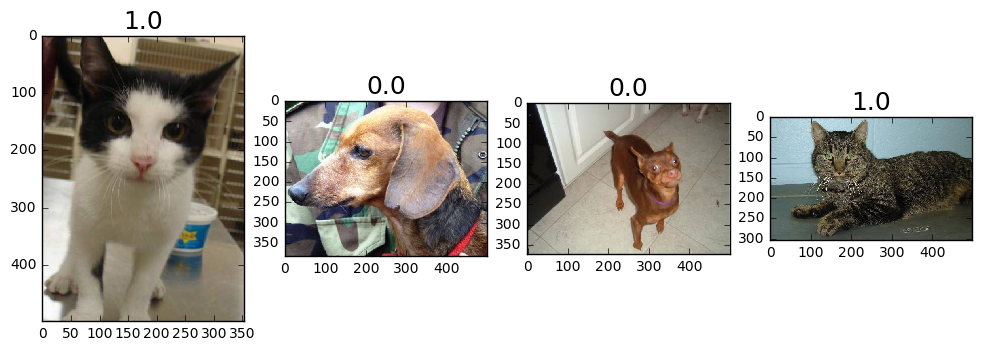

In [27]:
#1. A few correct labels at random
correct = np.where(preds==labels)[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

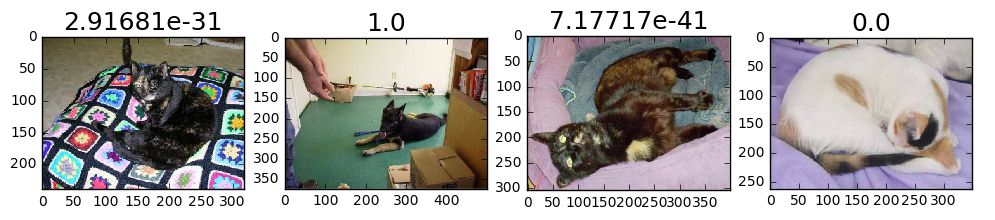

In [28]:
#2. A few incorrect labels at random
incorrect = np.where(preds!=labels)[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

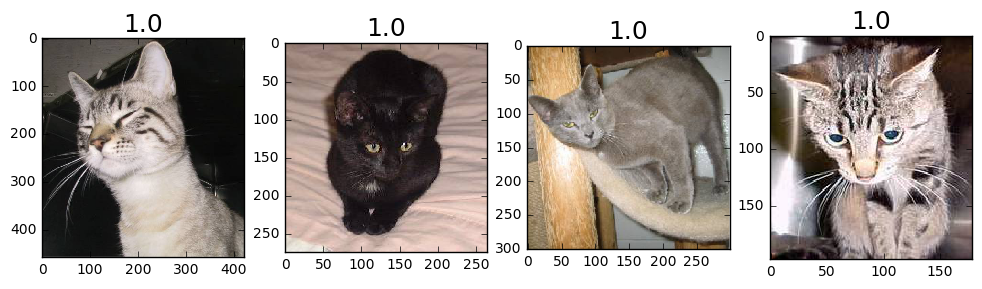

In [29]:
#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((preds==0) & (preds==labels))[0]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats])

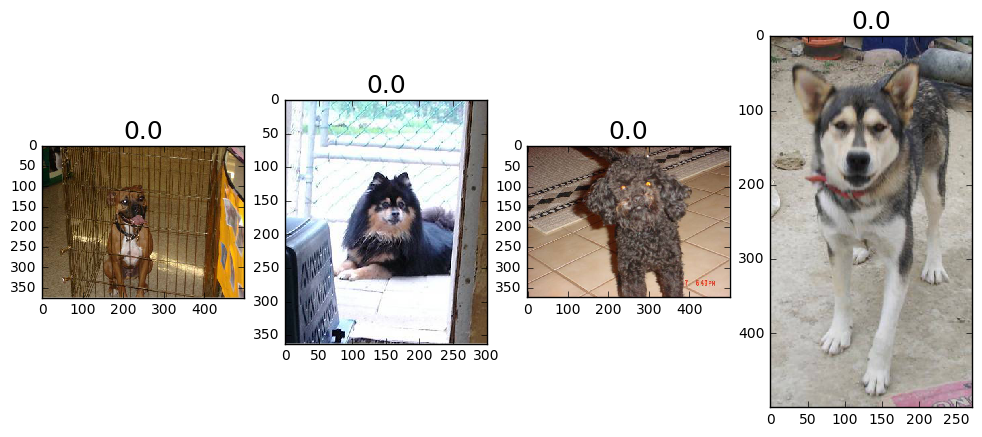

In [31]:
# as above, but dogs
correct_dogs = np.where((preds==1) & (preds==labels))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], probs[correct_dogs][most_correct_dogs])

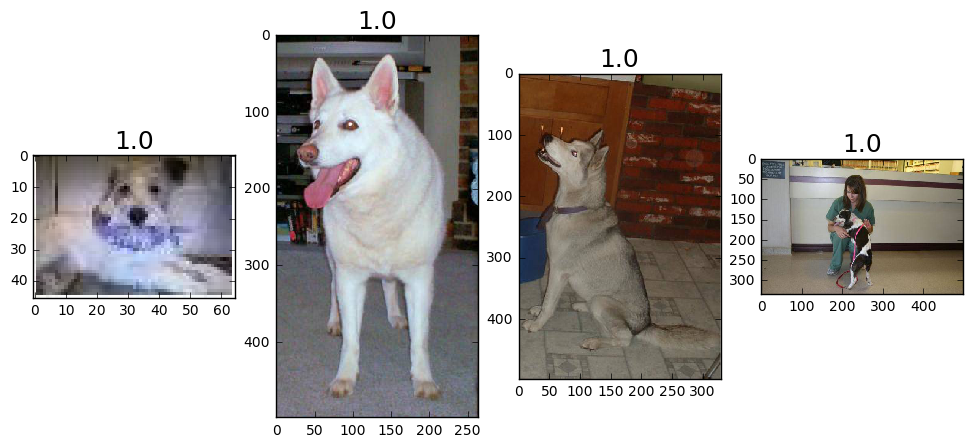

In [32]:
#3. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((preds==0) & (preds!=labels))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][:n_view]
plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])

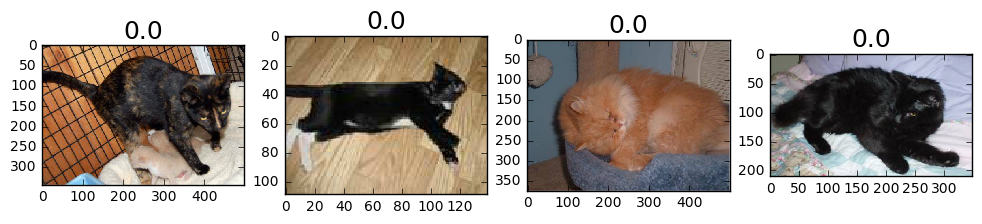

In [33]:
#3. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((preds==1) & (preds!=labels))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[:n_view]
plots_idx(incorrect_dogs[most_incorrect_dogs], probs[incorrect_dogs][most_incorrect_dogs])

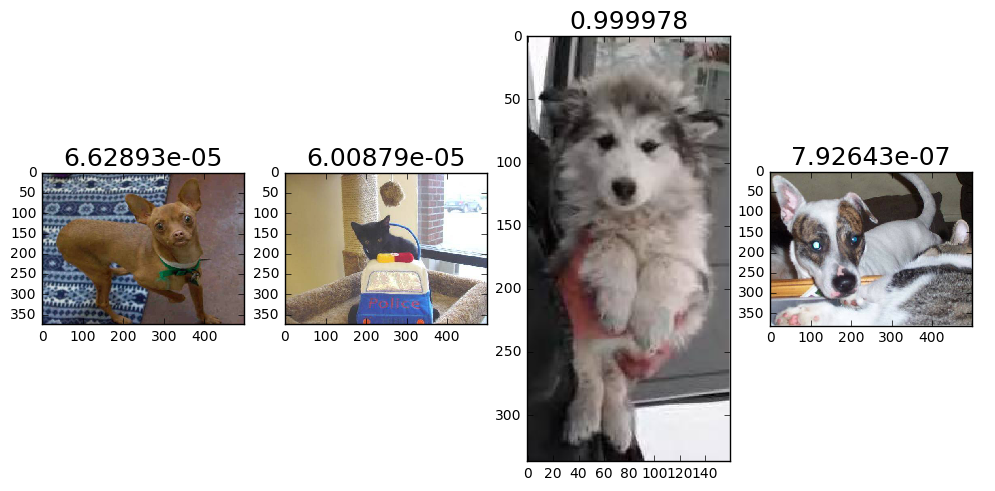

In [34]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [35]:
cm = confusion_matrix(labels, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[999  20]
 [ 30 951]]


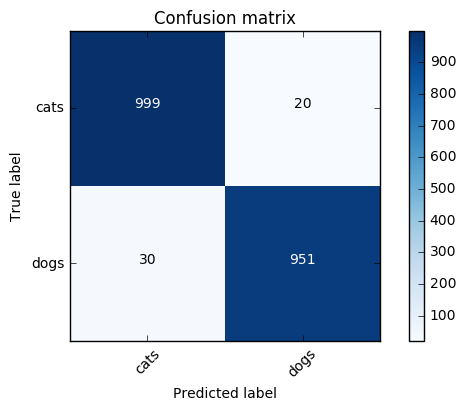

In [36]:
plot_confusion_matrix(cm, val_batches.class_indices)

In [14]:
isdog = np.clip(preds[:,1], 0.05, 0.95)